In [2]:
import itertools as it
import coba as cb

## Evaluating Policies From Logged Data

A common task when working with logged bandit feedback is to estimate how well a new policy would perform in the logged environment.

To perform off policy evaluation there are three common estimators used in the literature:

  1. Inverse Propensity Score (IPS) -- a higher-variance lower-bias estimator
  2. Direct Method (DM) -- a lower-variance higher-bias estimator
  3. Doubly Robust (DR) -- a lower-variance lower-bias estimator
  
We will evaluate all three of these methods against ground truth using 208 simulated datasets.


#### 1. Create our evaluation data

To create our logged data we use a `MisguidedLearner`. This learner will behave very differently from the evaluation policies.

In [107]:
envs1 = cb.Environments.cache_dir('.coba_cache').from_template('../templates/class208.json',n_take=10_000)
logs1 = envs.logged(cb.MisguidedLearner(cb.VowpalEpsilonLearner(),1,-1)).shuffle().chunk().ope_rewards([None,'IPS','DM','DR'])

#### 2. Define the experiment

In [104]:
experiment1 = cb.Experiment(logs1, cb.VowpalEpsilonLearner(), cb.OffPolicyEvaluator())

#### 3. Run the experiment

In [105]:
%%time
#WARNING: This can take some time to finish.
#WARNING: To simply see the results look below.
experiment1.run('out1.log.gz',processes=8,quiet=True)

Wall time: 12min 11s
{'Learners': 1, 'Environments': 832, 'Interactions': 6687624}


In [3]:
result1 = cb.Result.from_save('out1.log.gz')

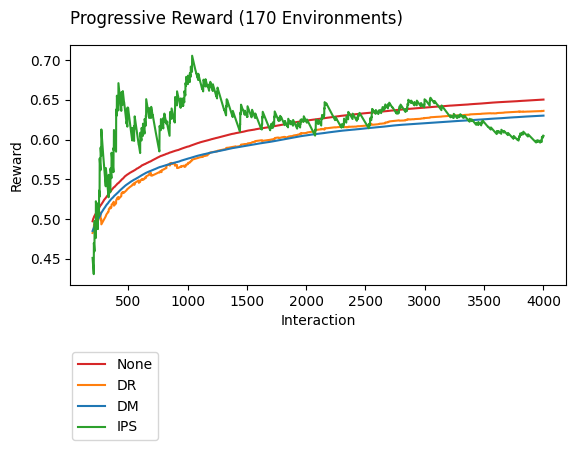

In [10]:
result1.filter_fin(4000).plot_learners(xlim=(200,None),l='ope_reward',p='openml_task')

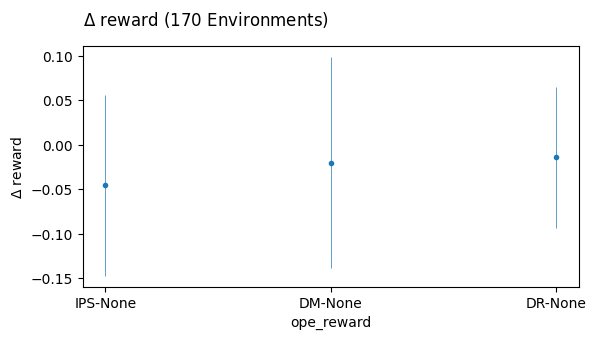

In [15]:
result1.filter_fin(4000).plot_contrast('None',['IPS','DM','DR'],x='ope_reward',l='ope_reward',p='openml_task',err='sd',boundary=False,legend=False)

---

## Evaluating Exploration From Logged

Our goal is to use logged data to estimate online exploration performance.

To do this we have three options:
  1. Perform on-policy evaluation using a reward estimator
  2. Perform off-policy evaluation using the logged data
  3. Use rejection sampling to make the logged data look like the desired exploration
  
We will evaluate all three options using logged data that we generate from a large set of classification datasets. By conducting this experiment over many datasets we can get a sense of the expected performance for each method independent of any one dataset. We will also intentionally use a misguided logging policy to generate our data to ensure that the logging policy doesn't look anything like the policies we wish to estimate.  

#### 1. Create evaluation data
To create our logged data we use a `MisguidedLearner`. This learner behaves very differently from the policies we want to evaluate.

In [2]:
envs2 = cb.Environments.cache_dir('.coba_cache').from_template('../templates/class208.json',n_take=100_000).where(n_interactions=100_000)
logs2 = envs.logged(cb.MisguidedLearner(cb.VowpalEpsilonLearner(),1,-1)).ope_rewards("DR").chunk()

#### 2. Define the experiment 

In [3]:
ground_truth  = it.product(envs2,[cb.VowpalEpsilonLearner()],[cb.OnPolicyEvaluator()])
first_option  = it.product(logs2,[cb.VowpalEpsilonLearner()],[cb.OnPolicyEvaluator()])
second_option = it.product(logs2,[cb.VowpalEpsilonLearner()],[cb.OffPolicyEvaluator()])
third_option  = it.product(logs2,[cb.VowpalEpsilonLearner()],[cb.ExplorationEvaluator()])

experiment2 = cb.Experiment(it.chain(ground_truth,first_option,second_option,third_option))

#### 3. Run the experiment

In [6]:
%%time
#WARNING: This can take some time to finish.
#WARNING: To simply see the results look below.
experiment2.run('out2.log.gz',processes=8,quiet=True)

Wall time: 1min 15s


#### 4. Analyze the results

We plot the experimental results to see which one of our three options best utilized the logged data to predict online performance.

In [25]:
result2 = cb.Result.from_save('out2.log.gz')
labels=['third option','second option','first option','ground truth']

Every openml_task not present for all ['ope_reward', 'eval_type'] has been excluded.
Interactions beyond the shortest openml_task have been excluded.


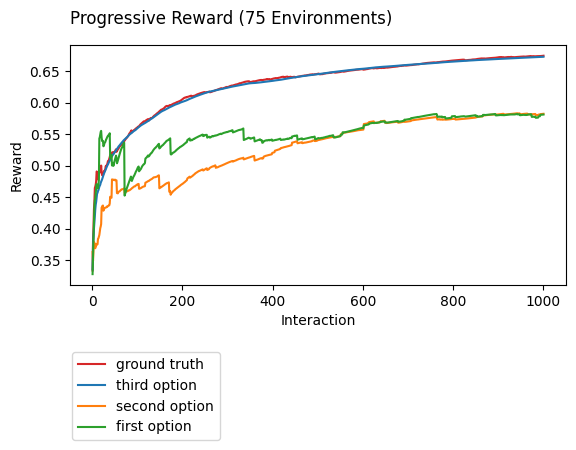

In [13]:
result2.filter_fin(1000).plot_learners(l=['ope_reward','eval_type'],p='openml_task',labels=labels)

In this plot the third option looks pretty good. It almost perfectly matches the average online performance across 75 unique classification datasets. Unfortunately, this plot isn't the full story. To get this accuracy we had to sacrafice some data. Notice that the plot above only has 1,000 interactions but our original dataset had 100,000 examples.

We now create a plot that shows the all 100,000 examples so we can see how much data we threw out when using the ExplorationEvaluator.

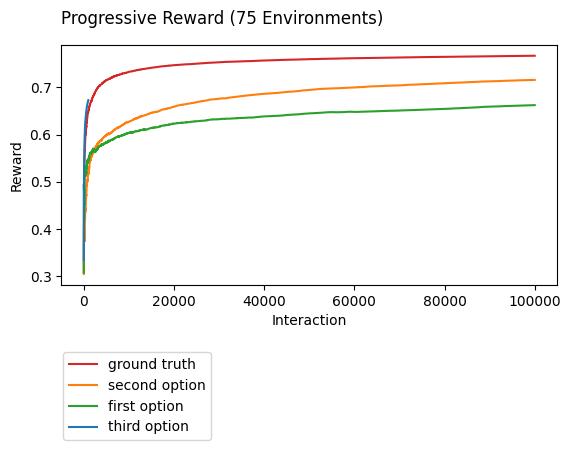

In [81]:
labels=['second option','first option','ground truth']

result2\
    .filter_val(eval_type={'!=':'ExplorationEvaluator'})\
    .plot_learners(l=['ope_reward','eval_type'],p='openml_task',labels=labels,colors=[1,2,3],out=None)

result2\
    .filter_val(eval_type={'=':'ExplorationEvaluator'})\
    .filter_fin(1000,['ope_reward','eval_type'],'openml_task')\
    .plot_learners(labels='third option',colors=0)